# Trends in Product Returns and Associated Revenue Loss (2020-2024)
##### August 21, 2025

The goal of this project was to:

1. Understand which items and categories have the largest impact on loss of revenue.
2. Quantify the financial impact of returns.
3. Identify trends from 2020 to 2024 to make informed business decisions.

## 1. Importing Necessary Libraries and Files

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# Import CSV File
df = pd.read_csv("C:\\Users\\Admin\\Documents\\Portfolio Case Studies\\Data Cleaning and Transformation\\online_sales_dataset.csv")

## 2. Review Current Data

### Data Types and Unique Values

In [2]:
# Checking the data types
print("Data Types:")
print(df.dtypes)
print("\n")

# Checking the number of unique values for each column
print("Number of Unique Values:")
print(df.nunique())

Data Types:
InvoiceNo              int64
StockCode             object
Description           object
Quantity               int64
InvoiceDate           object
UnitPrice            float64
CustomerID           float64
Country               object
Discount             float64
PaymentMethod         object
ShippingCost         float64
Category              object
SalesChannel          object
ReturnStatus          object
ShipmentProvider      object
WarehouseLocation     object
OrderPriority         object
dtype: object


Number of Unique Values:
InvoiceNo            48494
StockCode             1000
Description             11
Quantity                99
InvoiceDate          49782
UnitPrice            11200
CustomerID           35389
Country                 12
Discount              1047
PaymentMethod            3
ShippingCost          2501
Category                 5
SalesChannel             2
ReturnStatus             2
ShipmentProvider         4
WarehouseLocation        5
OrderPriority         

### Possible Mismatched Data

In [3]:
# Checking Category and Description for mismatched data
desc_category_check_all = (
    df.groupby('Description')['Category']
    .nunique()
    .reset_index(name='CategoryCount')
    .sort_values('CategoryCount', ascending=False)
)

# Checking descriptions appearing in more than one category
misaligned_desc_all = desc_category_check_all[desc_category_check_all['CategoryCount'] > 1]

print("\n--- Descriptions appearing in multiple categories ---")
print(misaligned_desc_all)


--- Descriptions appearing in multiple categories ---
       Description  CategoryCount
0         Backpack              5
1         Blue Pen              5
2        Desk Lamp              5
3       Headphones              5
4         Notebook              5
5     Office Chair              5
6          T-shirt              5
7        USB Cable              5
8       Wall Clock              5
9        White Mug              5
10  Wireless Mouse              5


In [4]:
# Getting the Top 2 descriptions per category
top2_per_category_all = (
    df.groupby(['Category', 'Description'])
    .size()
    .reset_index(name='Count')
    .sort_values(['Category', 'Count'], ascending=[True, False])
    .groupby('Category')
    .head(2)
    .reset_index(drop=True)
)

print("\n--- Top 2 Descriptions per Category (ALL ORDERS) ---")
print(top2_per_category_all)


--- Top 2 Descriptions per Category (ALL ORDERS) ---
      Category     Description  Count
0  Accessories      Wall Clock    949
1  Accessories       White Mug    940
2      Apparel      Headphones    926
3      Apparel       USB Cable    926
4  Electronics       USB Cable    958
5  Electronics      Wall Clock    929
6    Furniture        Backpack    973
7    Furniture  Wireless Mouse    946
8   Stationery      Wall Clock    938
9   Stationery        Blue Pen    929


In [5]:
# Checking SKU/StockCode for mismatched Descriptions
duplicate_descriptions = df[df.duplicated('Description', keep=False)].sort_values('Description')
duplicate_stockcodes = df[df.duplicated('StockCode', keep=False)].sort_values('StockCode')

print("\n--- Duplicate Descriptions ---")
print(duplicate_descriptions[['Description', 'Category']].drop_duplicates())

print("\n--- Duplicate StockCodes ---")
print(duplicate_stockcodes[['StockCode', 'Description', 'Category']].drop_duplicates())


--- Duplicate Descriptions ---
          Description     Category
34907        Backpack      Apparel
46580        Backpack  Accessories
33867        Backpack    Furniture
16540        Backpack   Stationery
4520         Backpack  Electronics
26807        Blue Pen      Apparel
26134        Blue Pen   Stationery
10903        Blue Pen  Electronics
11052        Blue Pen    Furniture
11126        Blue Pen  Accessories
12388       Desk Lamp    Furniture
42018       Desk Lamp   Stationery
46942       Desk Lamp  Accessories
30767       Desk Lamp      Apparel
12364       Desk Lamp  Electronics
22090      Headphones    Furniture
4382       Headphones      Apparel
47916      Headphones   Stationery
37166      Headphones  Accessories
45772      Headphones  Electronics
3031         Notebook    Furniture
30148        Notebook   Stationery
22381        Notebook  Accessories
20573        Notebook  Electronics
29324        Notebook      Apparel
35448    Office Chair   Stationery
41021    Office Chair  

## 3. Make Necessary Data Corrections

### Correcting Mismatched Data

In [6]:
# Correcting bad data to ensure that StockCode, Description, and Category are aligned
update_map = {
    "Backpack":         ("SKU_1000", "Backpack", "Accessories"),
    "Wall Clock":       ("SKU_1001", "Wall Clock", "Accessories"),
    "White Mug":        ("SKU_1002", "White Mug", "Accessories"),
    "T-shirt":          ("SKU_2000", "T-shirt", "Apparel"),
    "Headphones":       ("SKU_3000", "Headphones", "Electronics"),
    "USB Cable":        ("SKU_3001", "USB Cable", "Electronics"),
    "Wireless Mouse":   ("SKU_3002", "Wireless Mouse", "Electronics"),
    "Desk Lamp":        ("SKU_4000", "Desk Lamp", "Furniture"),
    "Office Chair":     ("SKU_4001", "Office Chair", "Furniture"),
    "Blue Pen":         ("SKU_5000", "Blue Pen", "Stationery"),
    "Notebook":         ("SKU_5001", "Notebook", "Stationery")
}

# Updating SKU, Description, and Category
def update_row(row):
    desc = row['Description']
    if desc in update_map:
        row['StockCode'], row['Description'], row['Category'] = update_map[desc]
    return row

df = df.apply(update_row, axis=1)

### Removing "SKU_" From the StockCode Column

In [7]:
# Removing "SKU_" from StockCode for ease of analysis
df["StockCode"] = df["StockCode"].astype(str).str.replace("SKU_", "", regex=False)

### Adjusting Invoice Date and Invoice Time

In [8]:
# Separate InvoiceDate into two columns - one for Date and one for Time
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df["Year"] = df["InvoiceDate"].dt.year  # Extract Year for analysis

In [9]:
# Remove any rows where Year is 2025
df = df[df["Year"] != 2025]

In [10]:
# Correct Date/Time format
invoice_time = df["InvoiceDate"].dt.strftime("%H:%M")  # HH:MM 24-hour format
df["InvoiceDate"] = df["InvoiceDate"].dt.date  # Keep only date
df.insert(df.columns.get_loc("InvoiceDate") + 1, "InvoiceTime", invoice_time)

### Rounding Decimals in the Discount column to Two Decimal Places for Consistency

In [11]:
# Rounding Discount column to two decimal places
df["Discount"] = df["Discount"].apply(lambda x: np.floor(x * 100) / 100)

## 4. Save the New Data

### Saving as a New File for Data Retention and Logging

In [12]:
# Saving updated data to new file
df.to_csv("updated_data_file.csv", index=False)
print("\n File saved as updated_data_file.csv")


 File saved as updated_data_file.csv


## 5. Generating Data Visualizations and Analysis

### Importing Updated Data File and Setting Data Frames

In [13]:
# Importing CSV File
df = pd.read_csv("C:\\Users\\Admin\\Documents\\Portfolio Case Studies\\Data Cleaning and Transformation\\updated_data_file.csv")

In [14]:
# Create LossOfRevenue column for returns only
df['LossOfRevenue'] = (df['UnitPrice'] + df['ShippingCost']) * df['Quantity']

# Count of ReturnStatus column
return_status_counts = df['ReturnStatus'].value_counts()

# Summary of Returned orders by CustomerID, Description, Category, SalesChannel, and OrderPriority
returned_df = df[df['ReturnStatus'] == 'Returned']

count_by_description = returned_df['Description'].value_counts()
count_by_customer = returned_df['CustomerID'].value_counts()
count_by_category = returned_df['Category'].value_counts()
count_by_saleschannel = returned_df['SalesChannel'].value_counts()
count_by_orderpriority = returned_df['OrderPriority'].value_counts()

# Loss of revenue per Category and Description
loss_by_category = (
    returned_df.groupby('Category')['LossOfRevenue']
    .sum()
    .reset_index()
    .sort_values('LossOfRevenue', ascending=False)
)

loss_by_description = (
    returned_df.groupby('Description')['LossOfRevenue']
    .sum()
    .reset_index()
    .sort_values('LossOfRevenue', ascending=False)
)

# Estimated Loss of Revenue on Returns by Year
loss_by_year = (
    returned_df.groupby('Year')['LossOfRevenue']
    .sum()
    .reset_index()
    .sort_values('LossOfRevenue', ascending=False)
)

# Count of Returns per Year per Category
returns_year_category = (
    returned_df.groupby(['Year', 'Category'])
    .size()
    .reset_index(name='Count')
    .sort_values('Count', ascending=False)
)

# Pivot table for plotting visualizations
pivot_returns = returns_year_category.pivot(index='Year', columns='Category', values='Count').fillna(0)

# Most Returned Description per Category
most_returned_per_category = (
    returned_df
    .groupby(['Category', 'Description'])
    .size()
    .reset_index(name='Count')
    .sort_values(['Category', 'Count'], ascending=[True, False])
    .groupby('Category')
    .head(1)
    .reset_index(drop=True)
)

### Reviewing the Trend of Returns by Category

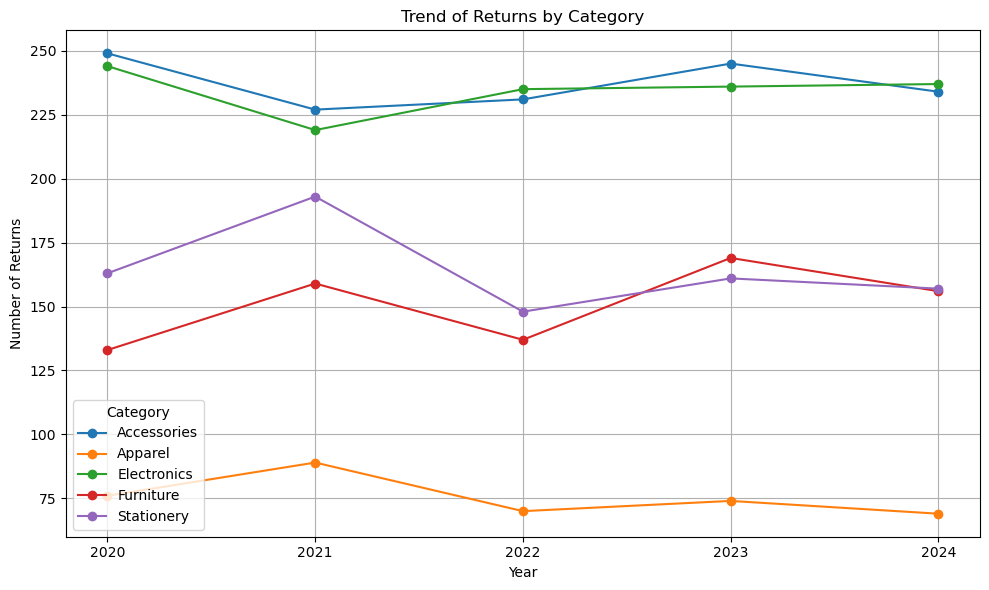

In [15]:
# Trend of Returns by Category
plt.figure(figsize=(10, 6))
for category in pivot_returns.columns:
    plt.plot(pivot_returns.index, pivot_returns[category], marker='o', label=category)

plt.title("Trend of Returns by Category")
plt.xlabel("Year")
plt.ylabel("Number of Returns")
plt.legend(title="Category")
plt.grid(True)

# Force x-axis to show only integer years
plt.xticks(ticks=range(int(pivot_returns.index.min()), int(pivot_returns.index.max()) + 1))

plt.tight_layout()
plt.savefig("trend_of_returns_by_category.png", dpi=300, bbox_inches="tight")
plt.show()


The categories for Electronics and Accessories are consistently the most returned items with Accessories being most returned for a longer duration of time.  Apparel contains the lowest number of returns year over year.

### Reviewing the Loss of Revenue by Category

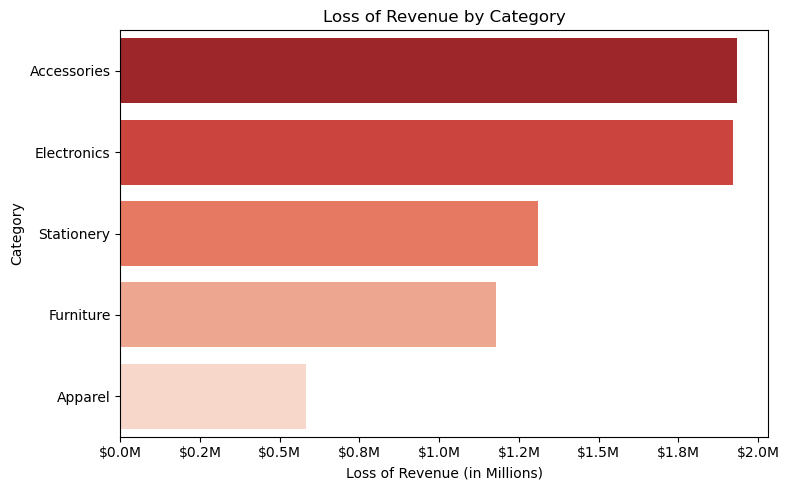

In [16]:
# Loss of Revenue by Category (Bar Chart)
plt.figure(figsize=(8, 5))
sns.barplot(
    data=loss_by_category,
    x='LossOfRevenue',
    y='Category',
    hue='Category',
    palette='Reds_r',
    legend=False
)

plt.title("Loss of Revenue by Category")
plt.xlabel("Loss of Revenue (in Millions)")
plt.ylabel("Category")

# Format x-axis in millions with $ sign
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x*1e-6:,.1f}M"))

plt.tight_layout()
plt.savefig("loss_of_revenue_by_category.png", dpi=300, bbox_inches="tight")
plt.show()


Accessories and Electronics contribute to the highest loss of revenue (in dollars) between the years 2020 and 2024.

### Reviewing the Most Frequently Returned Items by Description

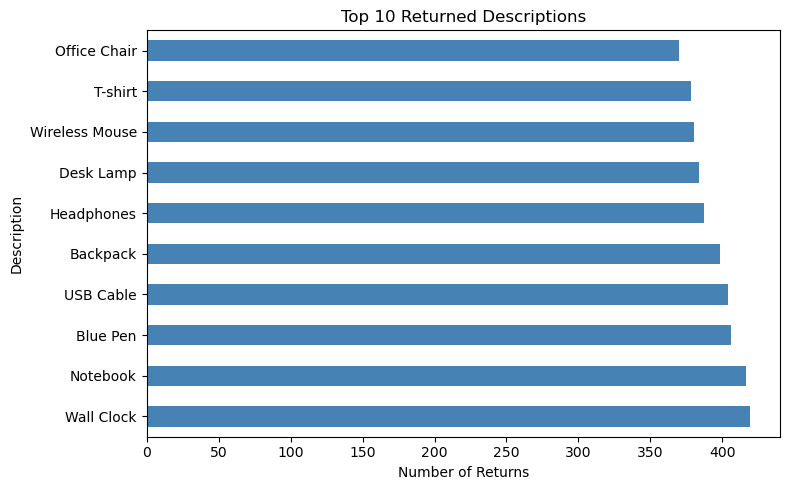

In [17]:
# Top Returned Descriptions (Bar Chart)
plt.figure(figsize=(8, 5))
count_by_description.head(10).plot(kind='barh', color='steelblue')
plt.title("Top 10 Returned Descriptions")
plt.xlabel("Number of Returns")
plt.ylabel("Description")
plt.tight_layout()
plt.savefig("top_10_returned_descriptions.png", dpi=300, bbox_inches="tight")
plt.show()

<b>Accessories Items:</b> The Wall Clock has 400 returns for the years 2020 through 2024, attributing to the high loss of revenue for Accessories items.

<b>Stationary Items:</b> The Notebook and Blue Pen have over 400 returns for the years 2020 through 2024, attributing to the high loss of revenue for Stationary items.

<b>Electronics Items:</b> The USB Cable is the highest returned Electronics item for years 2020 through 2024, attributing to the high loss of revenue for Electronics items.

### Reviewing the Overall Loss of Revenue by Year

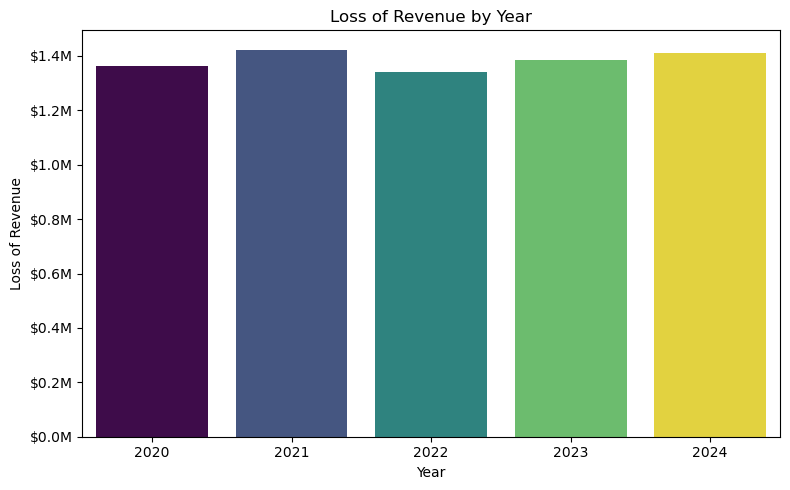

In [18]:
# Loss of Revenue by Year (Bar Chart)
plt.figure(figsize=(8, 5))
sns.barplot(
    data=loss_by_year,
    x='Year',
    y='LossOfRevenue',
    hue='Year',
    palette='viridis',
    legend=False
)
plt.title("Loss of Revenue by Year")
plt.xlabel("Year")
plt.ylabel("Loss of Revenue")

# Format y-axis in millions with $ sign
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x*1e-6:,.1f}M"))

plt.tight_layout()
plt.savefig("loss_of_revenue_by_year.png", dpi=300, bbox_inches="tight")
plt.show()

2021 saw the highest loss of revenue with year 2024 coming in just below it.

### Reviewing the Number of Returns per Year by Category

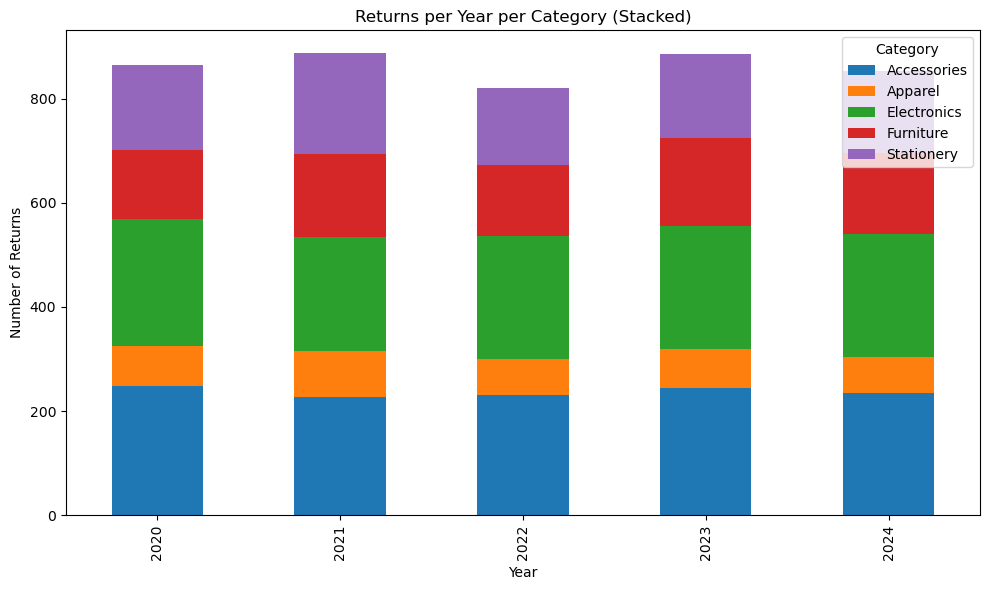

In [19]:
# Returns per Year per Category (Stacked Bar Chart)
pivot_returns.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Returns per Year per Category (Stacked)")
plt.xlabel("Year")
plt.ylabel("Number of Returns")
plt.tight_layout()
plt.savefig("returns_per_year_per_category_stacked.png", dpi=300, bbox_inches="tight")
plt.show()

The breakdown of returns per year by category displays the consistency of Accessories, Electronics, and Stationary returns by quantity affecting revenue loss per year.

### Reviewing the Percentage of Returns versus Not Returned

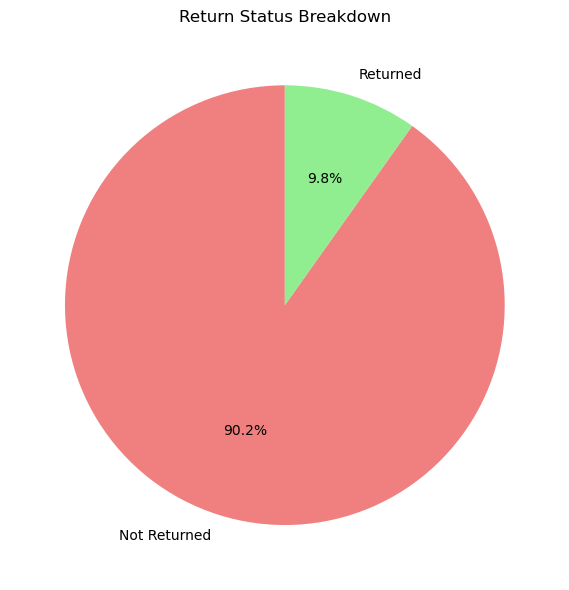

In [20]:
# Return Status Breakdown (Pie Chart)
plt.figure(figsize=(6, 6))
return_status_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen'])
plt.title("Return Status Breakdown")
plt.ylabel("")
plt.tight_layout()
plt.savefig("return_status_breakdown.png", dpi=300, bbox_inches="tight")
plt.show()

90.2% of orders are kept by the customer while 9.8% of orders are returned.  This emphasises the impact of such a small percentage of returns on loss of revenue.

### Printing Basic Numerical Data to Console for Additional Review

In [21]:
# Formatting for Currency
def format_currency(x):
    if isinstance(x, (int, float)):
        return f"${x:,.2f}"
    return x

In [22]:
# Display results in console
print("\n--- Total Count of ReturnStatus ---")
print(return_status_counts)

print("\n--- Count of Returned Orders by Description ---")
print(count_by_description)

print("\n--- Count of Returned Orders by CustomerID ---")
print(count_by_customer)

print("\n--- Count of Returned Orders by Category ---")
print(count_by_category)

print("\n--- Count of Returned Orders by SalesChannel ---")
print(count_by_saleschannel)

print("\n--- Count of Returned Orders by OrderPriority ---")
print(count_by_orderpriority)

print("\n--- Estimated Loss of Revenue by Category ---")
print(loss_by_category.map(format_currency))

print("\n--- Estimated Loss of Revenue by Description ---")
print(loss_by_description.map(format_currency))

print("\n--- Estimated Loss of Revenue on Returns by Year ---")
print(loss_by_year.map(format_currency))

print("\n--- Count of Returns per Year per Category ---")
print(returns_year_category)

print("\n--- Most Returned Description per Category ---")
print(most_returned_per_category)


--- Total Count of ReturnStatus ---
ReturnStatus
Not Returned    39537
Returned         4311
Name: count, dtype: int64

--- Count of Returned Orders by Description ---
Description
Wall Clock        419
Notebook          416
Blue Pen          406
USB Cable         404
Backpack          398
Headphones        387
Desk Lamp         384
Wireless Mouse    380
T-shirt           378
Office Chair      370
White Mug         369
Name: count, dtype: int64

--- Count of Returned Orders by CustomerID ---
CustomerID
68423.0    3
53125.0    3
29607.0    3
62222.0    2
69408.0    2
          ..
28145.0    1
59163.0    1
33161.0    1
31066.0    1
31943.0    1
Name: count, Length: 3790, dtype: int64

--- Count of Returned Orders by Category ---
Category
Accessories    1186
Electronics    1171
Stationery      822
Furniture       754
Apparel         378
Name: count, dtype: int64

--- Count of Returned Orders by SalesChannel ---
SalesChannel
Online      2174
In-store    2137
Name: count, dtype: int64

--- 

## 6. Next Steps

Deeper analysis on time-based trends, return reasoning, and inventory level patterns can be done to further pinpoint the root cause of returns with predictive modeling assisting in forecasting which orders are most likely to be returned.  A real-time, interactive dashboard would allow live tracking of returns and loss of revenue by specific criteria (year, category, sales channel) as the data is received to make quick business decisions.

1. <b>Strategic Planning:</b> Review of Return Policy and enhanced customer communication may benefit the number of returns being received as well as reviewing the quality of the supplier's product.
   
2. <b>Operational Improvements:</b> Adjusting the inventory retention levels for high-return products, reviewing quality control requirements, and optimizing shipment packaging and shipping methods for items that are returned frequently.